# Dynamic Network

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

df_dynamic_subset = pd.read_csv(r'C:\Users\MadiL\Thesis CodeBase\Longitudinal\Individual Questions\The 60\long_dynamic.csv')

# Initialize a dictionary to store networks for each time point
networks = {}

# Get unique time points in sorted order
time_points = sorted(df_dynamic_subset['YearMonth'].unique())


# Loop through each time point and build a network
for time_point in time_points:
    # Subset data for the current time point
    df_time = df_dynamic_subset[df_dynamic_subset['YearMonth'] == time_point]
    
    # Pivot to wide format (rows: participants, columns: questions)
    df_wide = df_time.pivot(index='Participant_Number', columns='Question', values='Score')
    
    # Compute correlation matrix
    corr_matrix = df_wide.corr()
    
    # Create a network using NetworkX (add edges for significant correlations)
    G = nx.Graph()
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > 0.4:  # Correlation threshold
                G.add_edge(corr_matrix.columns[i], corr_matrix.columns[j], weight=corr_matrix.iloc[i, j])
    
    # Store the network for the current time point
    networks[time_point] = G


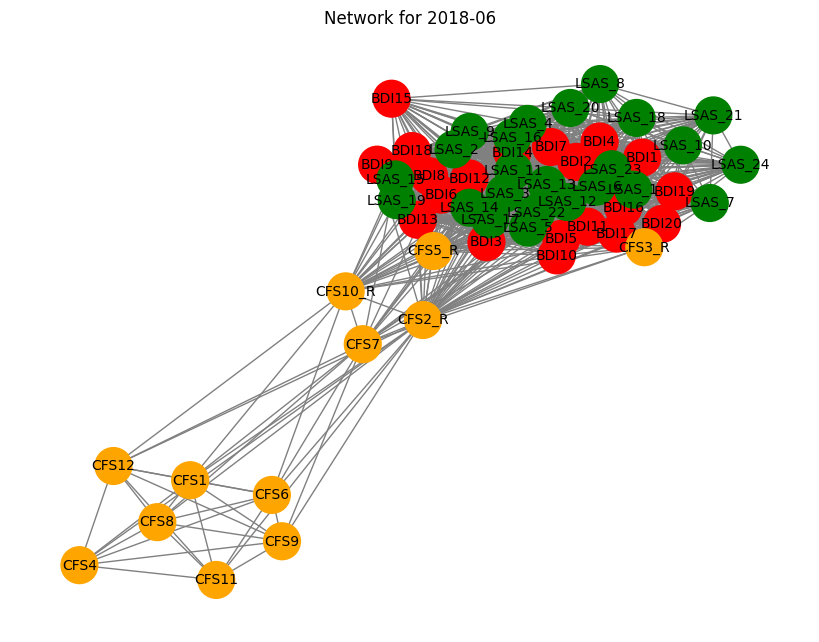

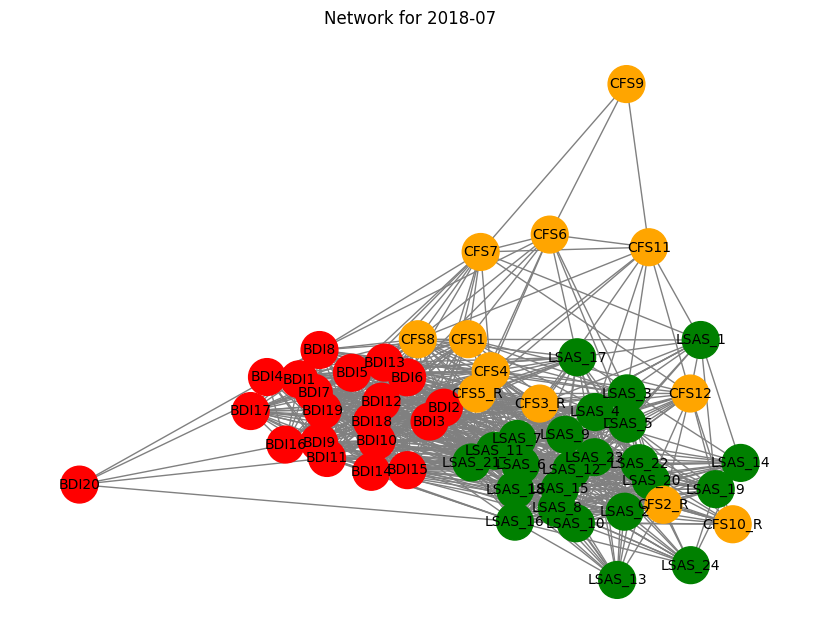

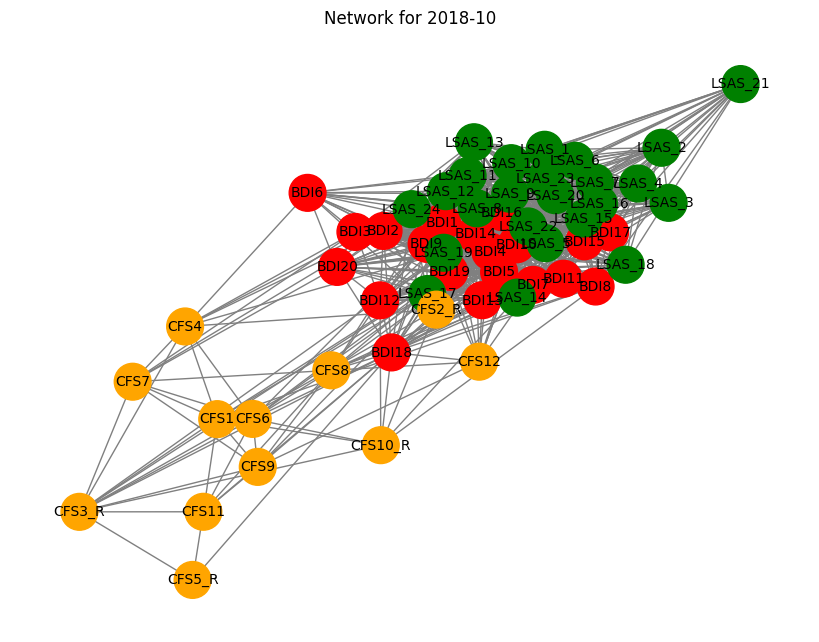

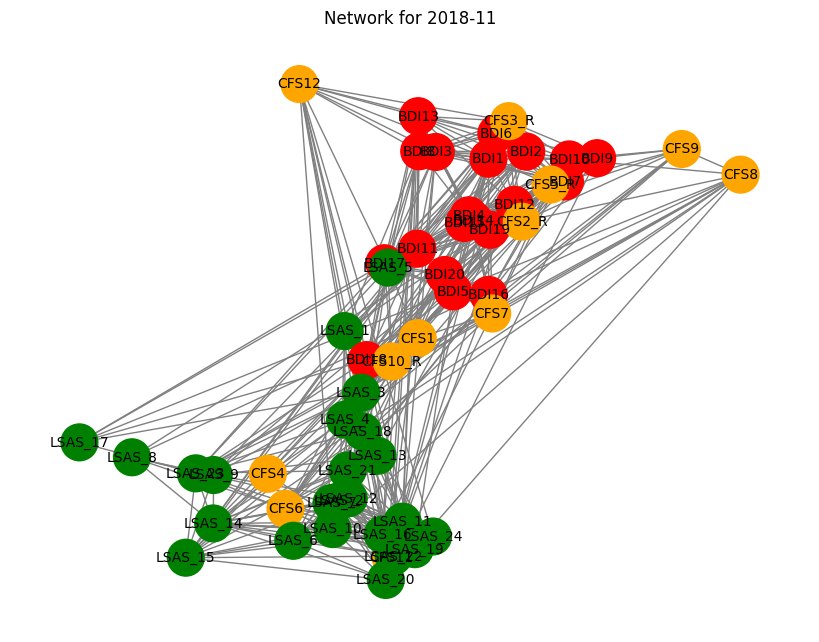

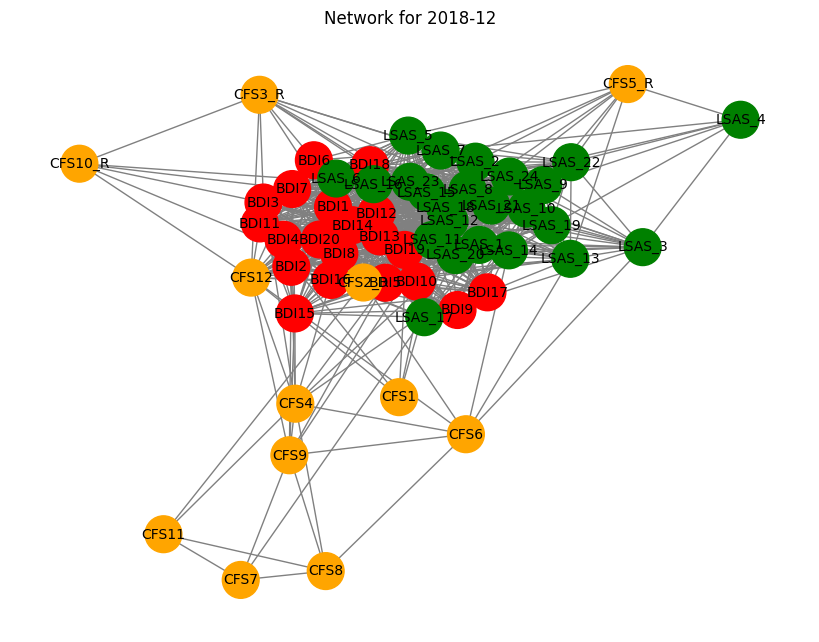

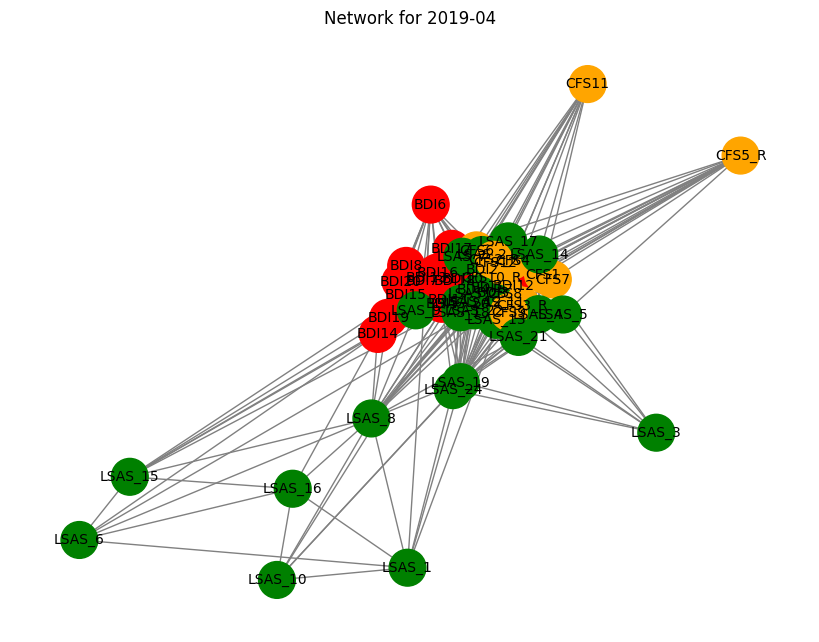

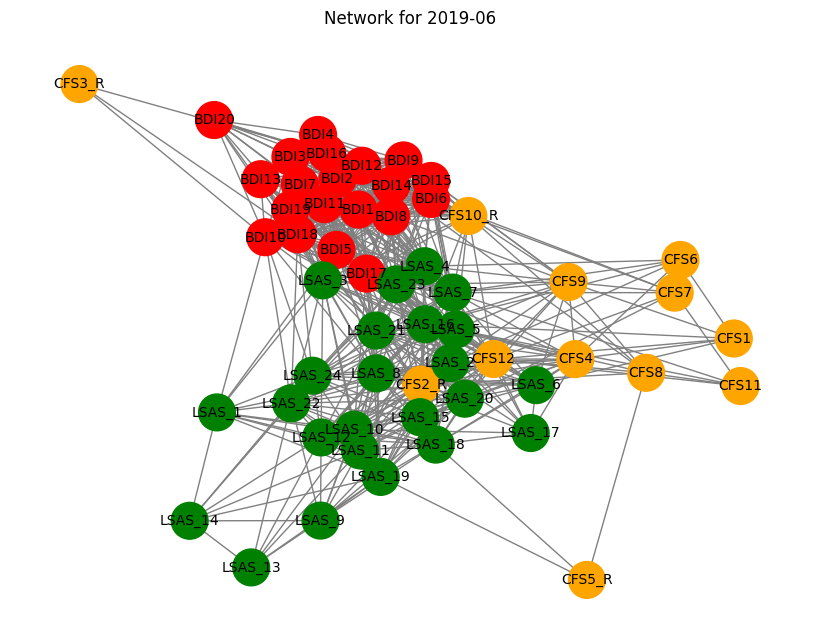

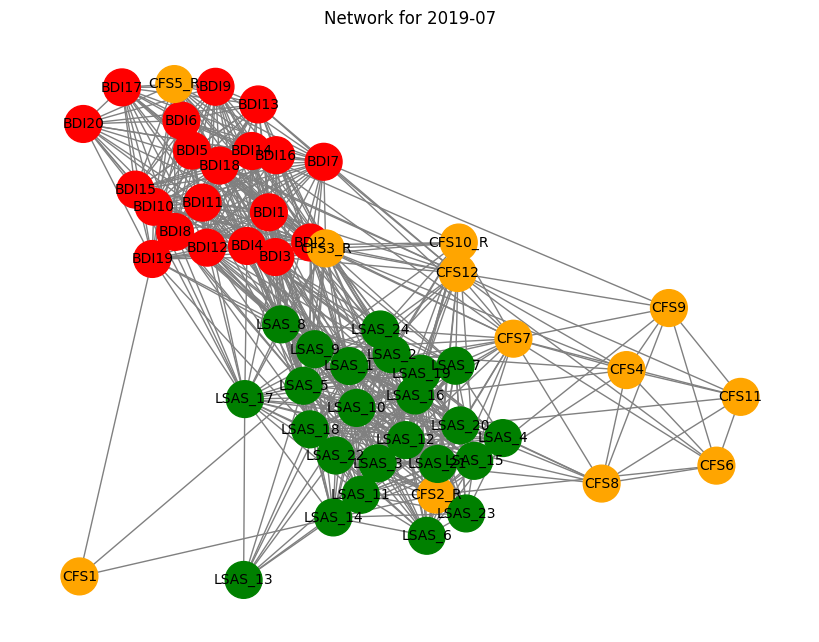

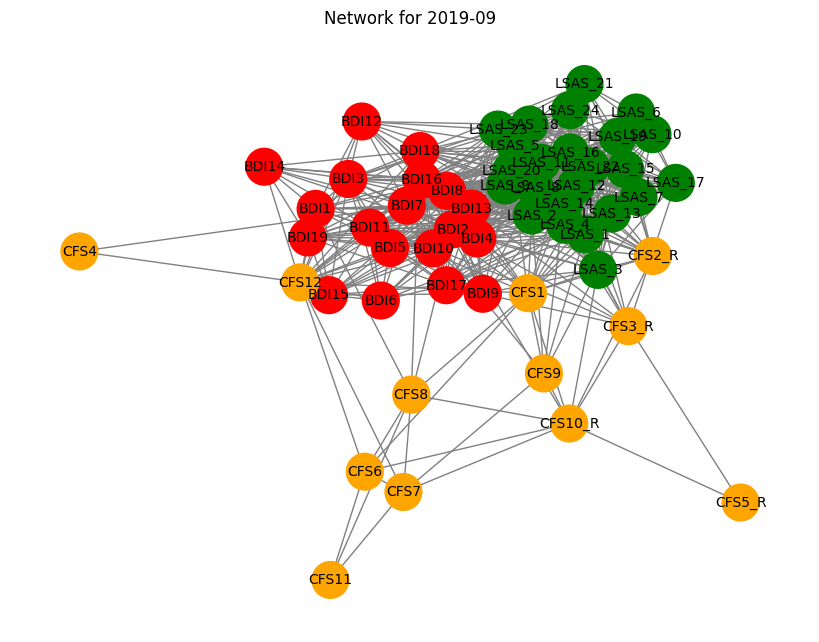

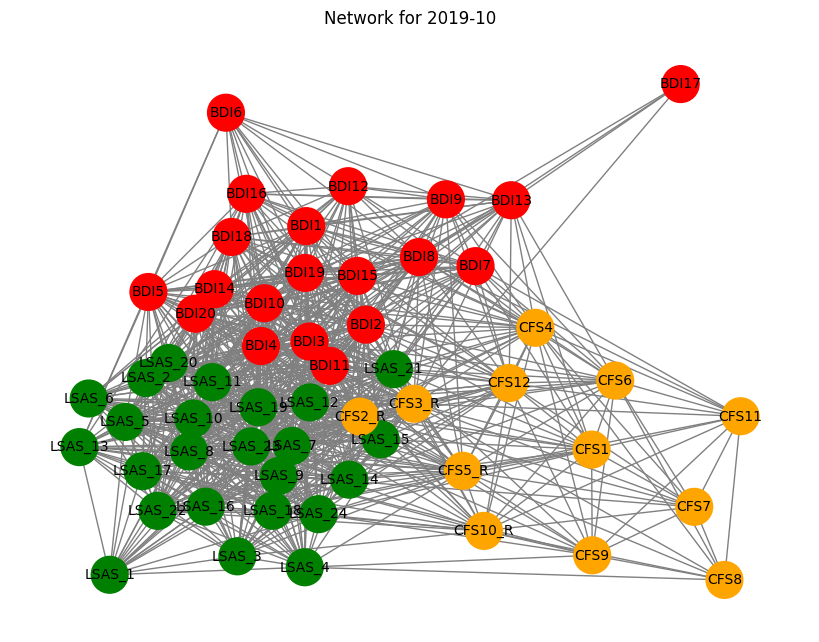

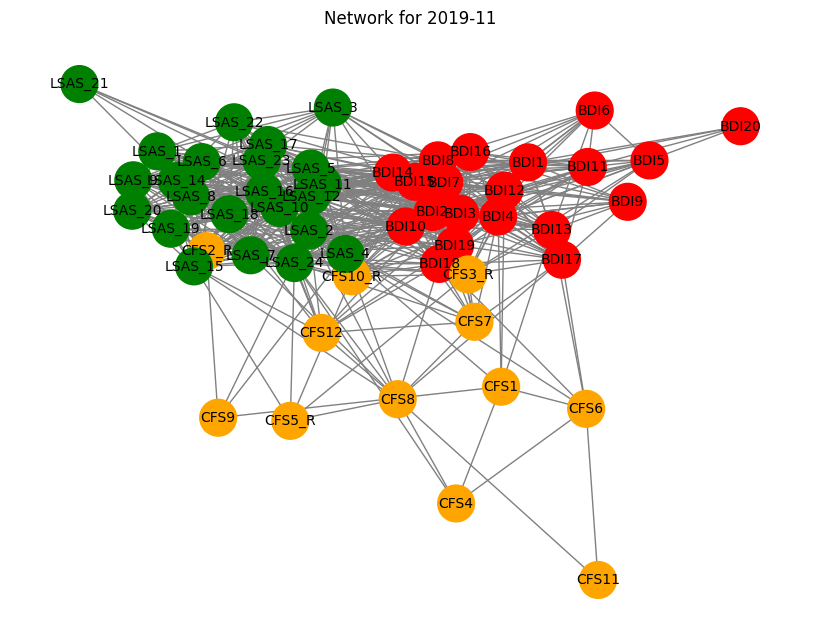

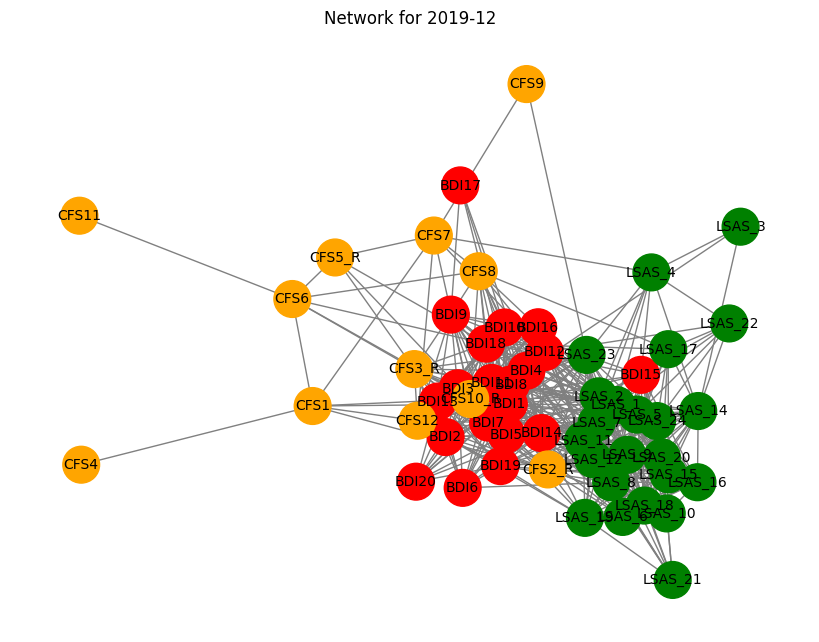

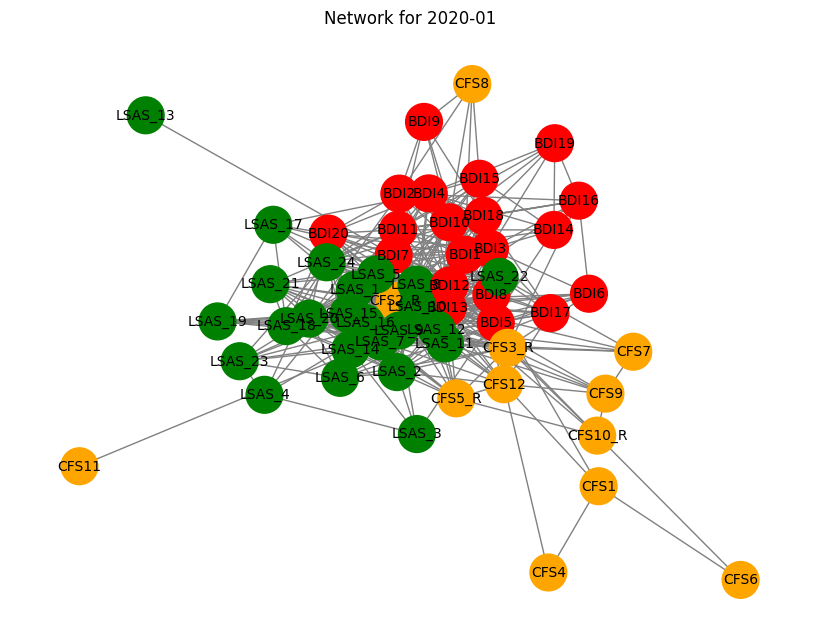

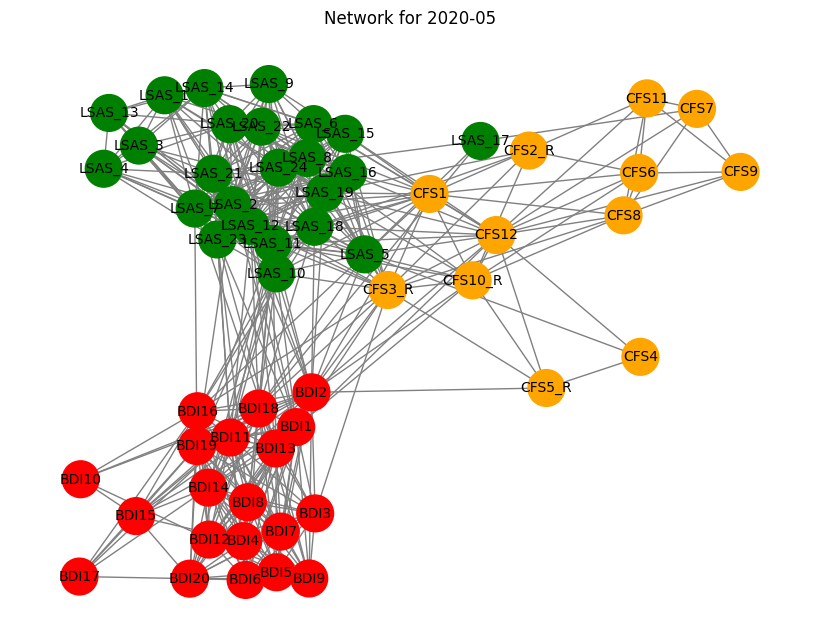

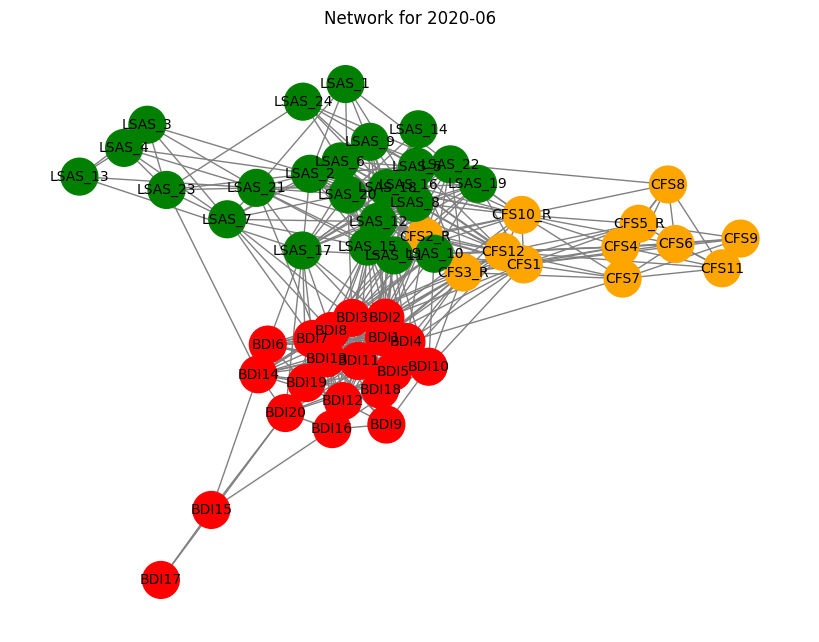

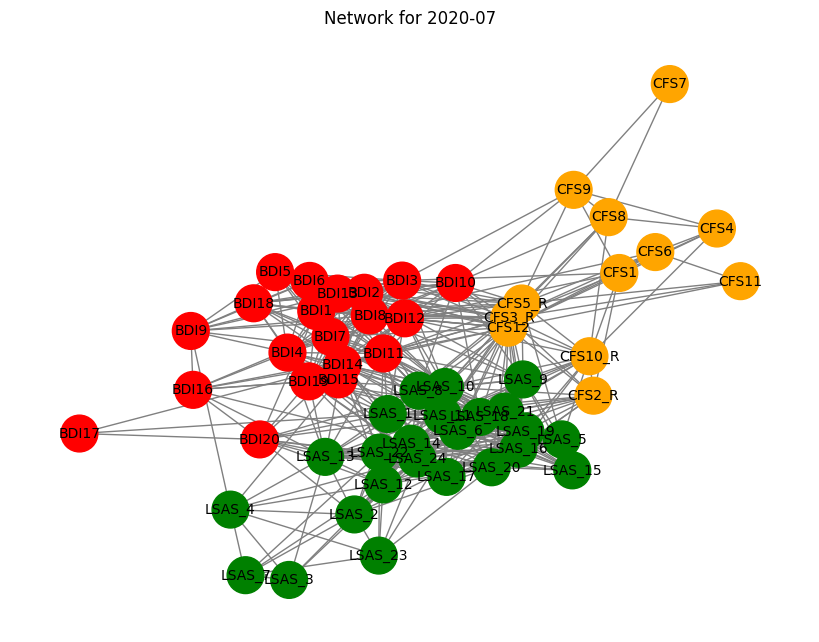

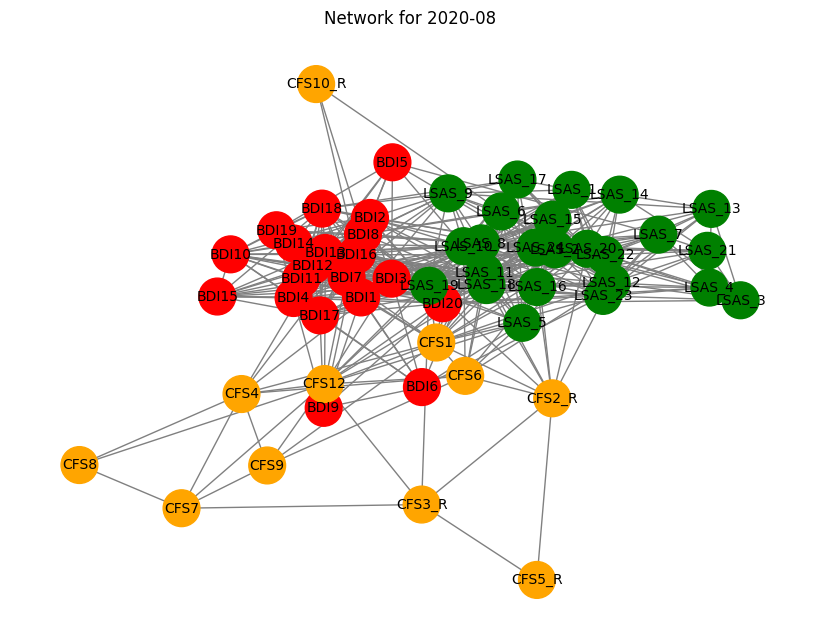

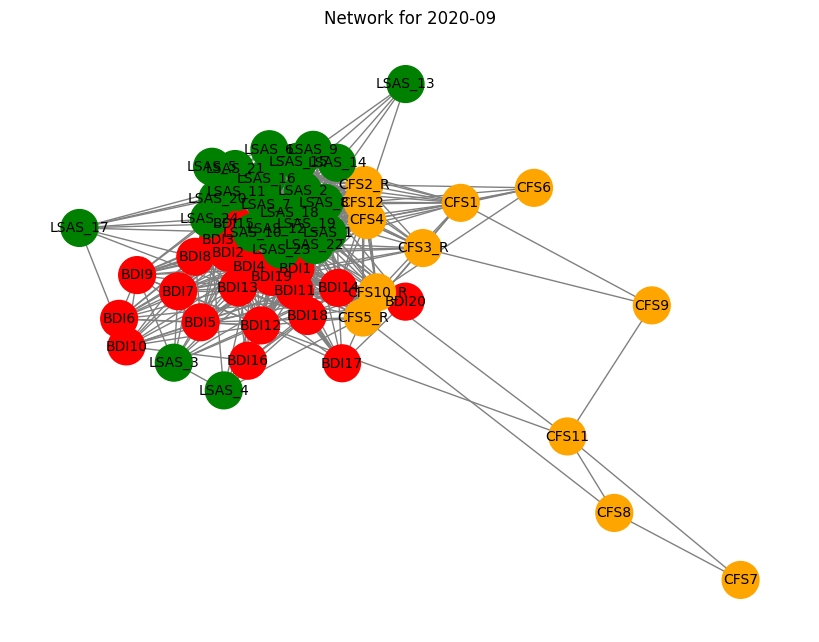

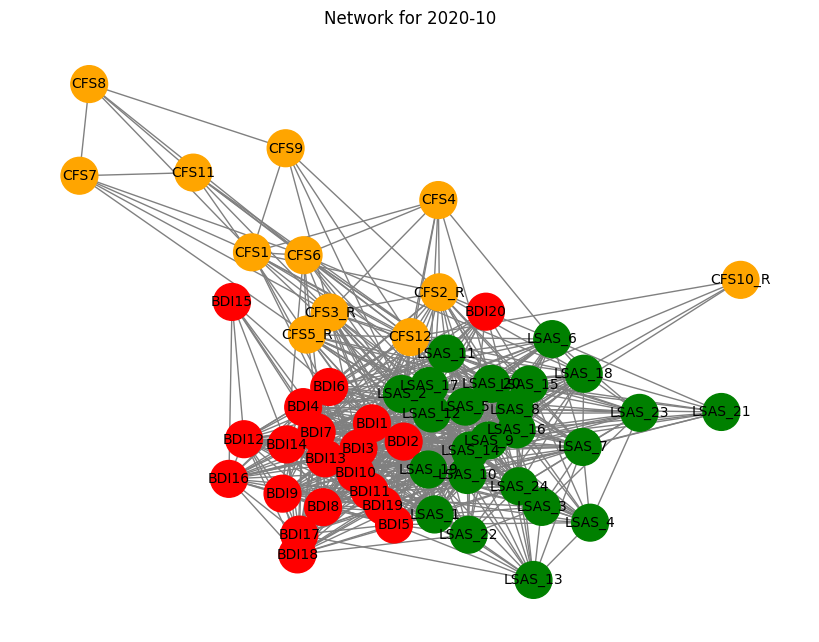

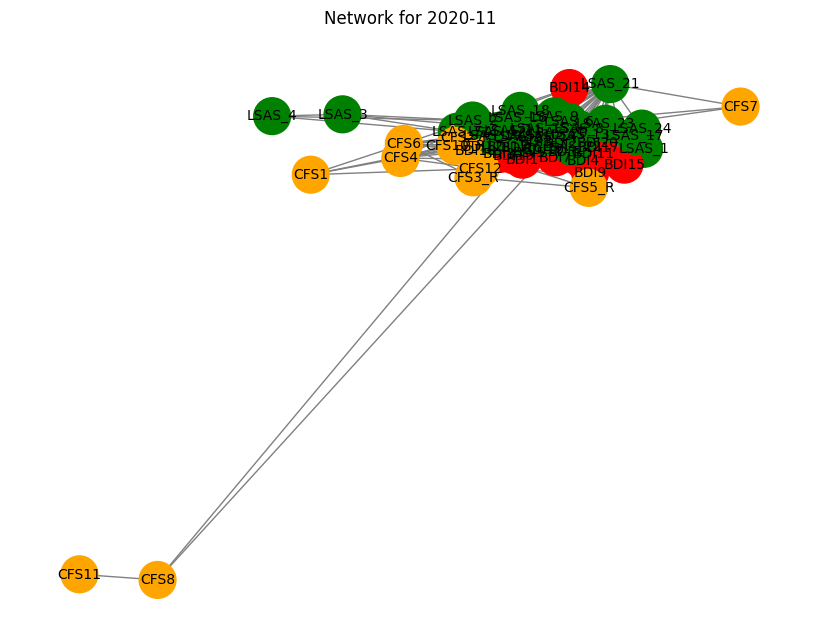

In [2]:
# Plot networks for selected time points

import matplotlib.pyplot as plt
import networkx as nx

# Define colors for different attributes
color_mapping = {
    'BDI': 'red',
    'LSAS': 'green',
    'CFS': 'orange',
    'default': 'gray'  # Default color if no attribute matches
}

# Function to assign colors based on node attributes
def get_node_color(node):
    if 'BDI' in node:
        return color_mapping['BDI']
    elif 'LSAS' in node:
        return color_mapping['LSAS']
    elif 'CFS' in node:
        return color_mapping['CFS']
    return color_mapping['default']

# Loop through networks and plot each graph
for time_point, G in networks.items():
    plt.figure(figsize=(8, 6))
    
    # Generate positions for nodes
    pos = nx.spring_layout(G, seed=42)
    
    # Assign colors to nodes
    node_colors = [get_node_color(node) for node in G.nodes]
    
    # Draw the network
    nx.draw(
        G, pos, with_labels=True, 
        node_color=node_colors, edge_color='gray', 
        node_size=700, font_size=10
    )
    
    plt.title(f"Network for {time_point}")
    plt.show()



In [4]:
# Community detection with positive correlations only
import community as community_louvain
from collections import defaultdict

# Initialize a dictionary to store community information
communities_over_time = {}

for time_point, G in networks.items():
    # Remove edges with negative weights
    G_positive = nx.Graph((u, v, d) for u, v, d in G.edges(data=True) if d['weight'] > 0)
    
    # Apply Louvain method
    partition = community_louvain.best_partition(G_positive)
    communities_over_time[time_point] = partition

# Identify top 3 hub nodes by weighted degree over time
hub_nodes_over_time = {}

for time_point, G in networks.items():
    weighted_degree = dict(G.degree(weight='weight'))
    sorted_hubs = sorted(weighted_degree.items(), key=lambda x: x[1], reverse=True)[:3]
    hub_nodes_over_time[time_point] = [node for node, _ in sorted_hubs]

# Display top 3 hubs over time
print("Top 3 hubs over time:")
for time_point, hubs in hub_nodes_over_time.items():
    print(f"  {time_point}: {hubs}")

# Summary of average degree and clustering coefficient over time
summary_metrics = {
    'Time Point': [],
    'Average Degree': [],
    'Clustering Coefficient': []
}

for time_point, G in networks.items():
    avg_degree = sum(dict(G.degree()).values()) / G.number_of_nodes()
    clustering_coeff = nx.average_clustering(G)
    summary_metrics['Time Point'].append(time_point)
    summary_metrics['Average Degree'].append(avg_degree)
    summary_metrics['Clustering Coefficient'].append(clustering_coeff)

# Convert summary metrics to a DataFrame and display
summary_df = pd.DataFrame(summary_metrics)
print("\nSummary of Average Degree and Clustering Coefficient over Time:")
print(summary_df)

# Example: Track community changes for a specific node (BDI1)
example_node = 'BDI1'
print(f"\nCommunity membership of {example_node} over time:")
for time_point, partition in communities_over_time.items():
    if example_node in partition:
        print(f"  {time_point}: Community {partition[example_node]}")


Top 3 hubs over time:
  2018-06: ['LSAS_14', 'LSAS_22', 'BDI16']
  2018-07: ['LSAS_11', 'LSAS_7', 'BDI2']
  2018-10: ['LSAS_22', 'BDI16', 'BDI10']
  2018-11: ['BDI4', 'BDI14', 'BDI1']
  2018-12: ['LSAS_11', 'LSAS_12', 'LSAS_18']
  2019-04: ['LSAS_23', 'LSAS_20', 'BDI11']
  2019-06: ['LSAS_7', 'LSAS_23', 'BDI18']
  2019-07: ['CFS3_R', 'LSAS_1', 'BDI4']
  2019-09: ['BDI2', 'LSAS_20', 'LSAS_9']
  2019-10: ['BDI3', 'LSAS_12', 'CFS2_R']
  2019-11: ['LSAS_11', 'LSAS_2', 'BDI7']
  2019-12: ['LSAS_11', 'BDI14', 'BDI4']
  2020-01: ['BDI13', 'LSAS_10', 'LSAS_8']
  2020-05: ['LSAS_11', 'LSAS_12', 'BDI2']
  2020-06: ['LSAS_11', 'BDI2', 'BDI3']
  2020-07: ['BDI11', 'LSAS_10', 'LSAS_6']
  2020-08: ['LSAS_19', 'BDI3', 'LSAS_18']
  2020-09: ['LSAS_19', 'LSAS_12', 'LSAS_1']
  2020-10: ['LSAS_2', 'BDI1', 'BDI2']
  2020-11: ['LSAS_10', 'LSAS_5', 'LSAS_11']

Summary of Average Degree and Clustering Coefficient over Time:
   Time Point  Average Degree  Clustering Coefficient
0     2018-06       37.928571  

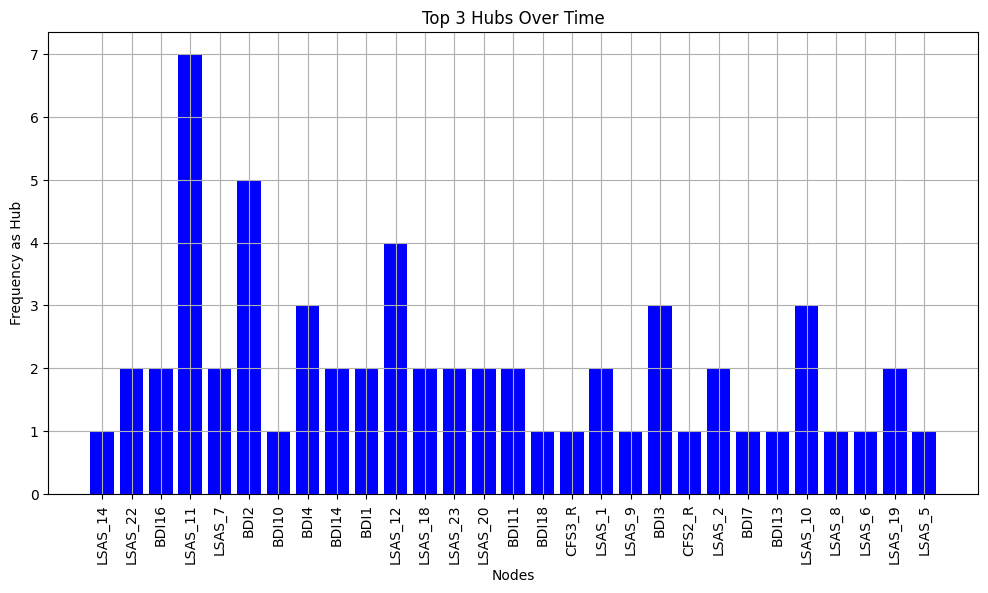

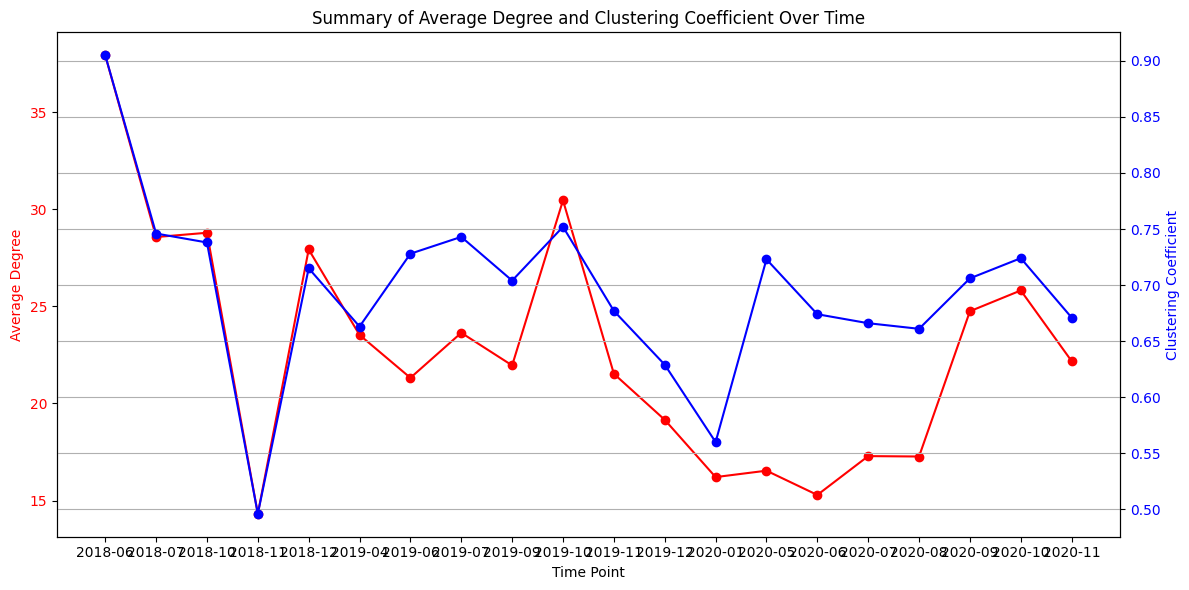

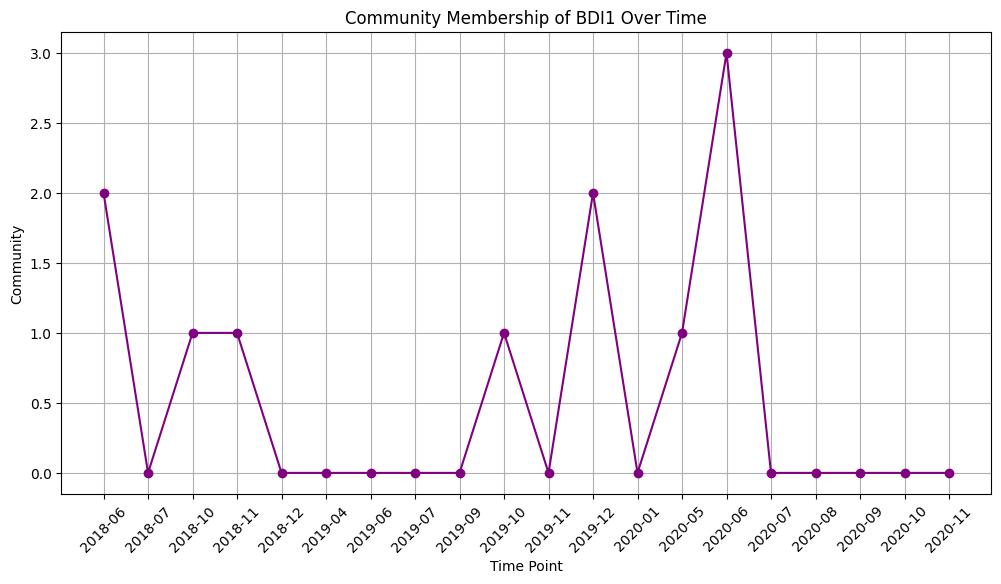

In [5]:
import matplotlib.pyplot as plt

# Data for visualization
hub_nodes = {
    '2018-06': ['LSAS_14', 'LSAS_22', 'BDI16'],
    '2018-07': ['LSAS_11', 'LSAS_7', 'BDI2'],
    '2018-10': ['LSAS_22', 'BDI16', 'BDI10'],
    '2018-11': ['BDI4', 'BDI14', 'BDI1'],
    '2018-12': ['LSAS_11', 'LSAS_12', 'LSAS_18'],
    '2019-04': ['LSAS_23', 'LSAS_20', 'BDI11'],
    '2019-06': ['LSAS_7', 'LSAS_23', 'BDI18'],
    '2019-07': ['CFS3_R', 'LSAS_1', 'BDI4'],
    '2019-09': ['BDI2', 'LSAS_20', 'LSAS_9'],
    '2019-10': ['BDI3', 'LSAS_12', 'CFS2_R'],
    '2019-11': ['LSAS_11', 'LSAS_2', 'BDI7'],
    '2019-12': ['LSAS_11', 'BDI14', 'BDI4'],
    '2020-01': ['BDI13', 'LSAS_10', 'LSAS_8'],
    '2020-05': ['LSAS_11', 'LSAS_12', 'BDI2'],
    '2020-06': ['LSAS_11', 'BDI2', 'BDI3'],
    '2020-07': ['BDI11', 'LSAS_10', 'LSAS_6'],
    '2020-08': ['LSAS_19', 'BDI3', 'LSAS_18'],
    '2020-09': ['LSAS_19', 'LSAS_12', 'LSAS_1'],
    '2020-10': ['LSAS_2', 'BDI1', 'BDI2'],
    '2020-11': ['LSAS_10', 'LSAS_5', 'LSAS_11']
}

summary_metrics = {
    'Time Point': [
        '2018-06', '2018-07', '2018-10', '2018-11', '2018-12',
        '2019-04', '2019-06', '2019-07', '2019-09', '2019-10',
        '2019-11', '2019-12', '2020-01', '2020-05', '2020-06',
        '2020-07', '2020-08', '2020-09', '2020-10', '2020-11'
    ],
    'Average Degree': [
        37.93, 28.57, 28.79, 14.32, 27.93, 23.53, 21.32, 23.64,
        21.96, 30.46, 21.53, 19.16, 16.21, 16.54, 15.29, 17.29,
        17.27, 24.75, 25.82, 22.18
    ],
    'Clustering Coefficient': [
        0.905, 0.746, 0.738, 0.496, 0.715, 0.663, 0.728, 0.743,
        0.704, 0.752, 0.677, 0.629, 0.560, 0.723, 0.674, 0.666,
        0.661, 0.706, 0.724, 0.671
    ]
}

community_membership = {
    '2018-06': 2, '2018-07': 0, '2018-10': 1, '2018-11': 1,
    '2018-12': 0, '2019-04': 0, '2019-06': 0, '2019-07': 0,
    '2019-09': 0, '2019-10': 1, '2019-11': 0, '2019-12': 2,
    '2020-01': 0, '2020-05': 1, '2020-06': 3, '2020-07': 0,
    '2020-08': 0, '2020-09': 0, '2020-10': 0, '2020-11': 0
}

# Visualization 1: Top 3 Hubs Over Time
hub_counts = {}
for hubs in hub_nodes.values():
    for hub in hubs:
        hub_counts[hub] = hub_counts.get(hub, 0) + 1

plt.figure(figsize=(12, 6))
plt.bar(hub_counts.keys(), hub_counts.values(), color='blue')
plt.xticks(rotation=90)
plt.xlabel('Nodes')
plt.ylabel('Frequency as Hub')
plt.title('Top 3 Hubs Over Time')
plt.grid(True)
plt.show()

# Visualization 2: Summary Metrics Over Time
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(summary_metrics['Time Point'], summary_metrics['Average Degree'], marker='o', color='red', label='Average Degree')
ax1.set_xlabel('Time Point')
ax1.set_ylabel('Average Degree', color='red')
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()
ax2.plot(summary_metrics['Time Point'], summary_metrics['Clustering Coefficient'], marker='o', color='blue', label='Clustering Coefficient')
ax2.set_ylabel('Clustering Coefficient', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

plt.title('Summary of Average Degree and Clustering Coefficient Over Time')
fig.tight_layout()
plt.grid(True)
plt.show()

# Visualization 3: Community Membership of BDI1 Over Time
plt.figure(figsize=(12, 6))
plt.plot(list(community_membership.keys()), list(community_membership.values()), marker='o', color='purple')
plt.xticks(rotation=45)
plt.xlabel('Time Point')
plt.ylabel('Community')
plt.title('Community Membership of BDI1 Over Time')
plt.grid(True)
plt.show()


# Granger Causality

## Means

c:\Users\MadiL\Thesis CodeBase\thesisenv\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\MadiL\Thesis CodeBase\thesisenv\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


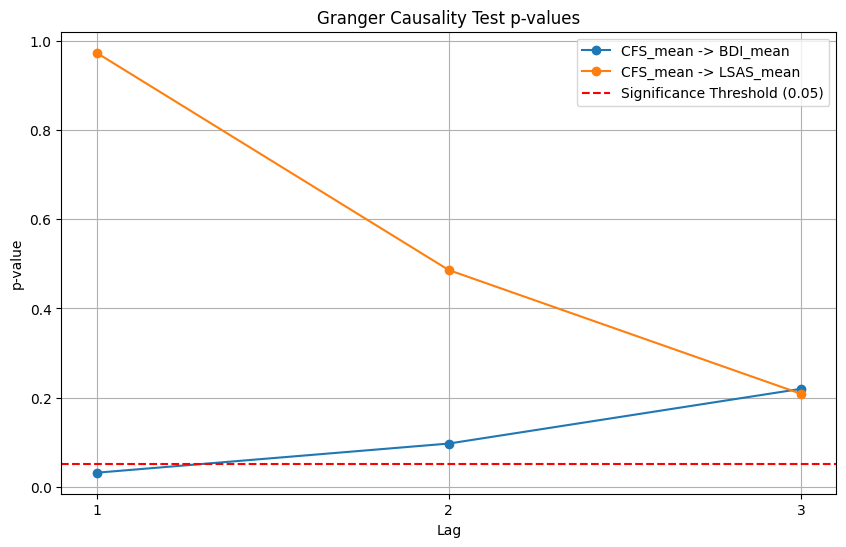

In [8]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests

# Load the dataset
df_dynamic_subset = pd.read_csv(r'C:\Users\MadiL\Thesis CodeBase\Longitudinal\Individual Questions\The 60\long_dynamic.csv')

# Step 1: Clean the data to ensure no formatting issues
df_dynamic_subset['Question'] = df_dynamic_subset['Question'].str.strip()

# Step 2: Aggregate duplicate entries by taking the mean score for each combination
df_aggregated = df_dynamic_subset.groupby(['YearMonth', 'Participant_Number', 'Question']).mean().reset_index()

# Step 3: Pivot the dataset to wide format
df_pivot = df_aggregated.pivot_table(index='YearMonth', columns='Question', values='Score', aggfunc='mean').sort_index()

# Step 4: Select columns related to CFS, BDI, and LSAS
cfs_columns = [col for col in df_pivot.columns if 'CFS' in col]
bdi_columns = [col for col in df_pivot.columns if 'BDI' in col]
lsas_columns = [col for col in df_pivot.columns if 'LSAS' in col]

# Step 5: Compute the mean score across items for each group at each time point
df_mean_scores = pd.DataFrame({
    'CFS_mean': df_pivot[cfs_columns].mean(axis=1),
    'BDI_mean': df_pivot[bdi_columns].mean(axis=1),
    'LSAS_mean': df_pivot[lsas_columns].mean(axis=1)
}).dropna()  # Drop rows with NaN values

# Step 6: Run Granger causality tests
# Test if CFS_mean Granger-causes BDI_mean
granger_result_bdi = grangercausalitytests(df_mean_scores[['CFS_mean', 'BDI_mean']], maxlag=3, verbose=False)

# Test if CFS_mean Granger-causes LSAS_mean
granger_result_lsas = grangercausalitytests(df_mean_scores[['CFS_mean', 'LSAS_mean']], maxlag=3, verbose=False)

# Step 7: Extract p-values for Granger causality tests
p_values_bdi = [granger_result_bdi[lag][0]['ssr_ftest'][1] for lag in granger_result_bdi]
p_values_lsas = [granger_result_lsas[lag][0]['ssr_ftest'][1] for lag in granger_result_lsas]

# Step 8: Visualize p-values over different lags
lags = range(1, 4)
plt.figure(figsize=(10, 6))
plt.plot(lags, p_values_bdi, marker='o', label='CFS_mean -> BDI_mean')
plt.plot(lags, p_values_lsas, marker='o', label='CFS_mean -> LSAS_mean')
plt.axhline(y=0.05, color='red', linestyle='--', label='Significance Threshold (0.05)')
plt.xticks(lags)
plt.xlabel('Lag')
plt.ylabel('p-value')
plt.title('Granger Causality Test p-values')
plt.legend()
plt.grid(True)
plt.show()


### Mean Granger Causality Interpretation
The Granger causality test results show whether past values of one time series (in this case, the mean CFS scores) can predict future values of another time series (BDI or LSAS scores). 

Lags:
A lag of 1 means we are testing whether CFS scores from one time point earlier can predict BDI or LSAS scores at the current time point.

A lag of 2 tests whether CFS scores from two time points earlier can predict current BDI or LSAS scores, and so on.

Significance:
A p-value below 0.05 at a given lag suggests significant Granger causality, meaning the past values of CFS significantly predict current values of BDI or LSAS at that lag. In our analysis, CFS scores significantly Granger-cause BDI scores at lags 1 and 2, but not LSAS scores, indicating a potential causative relationship where changes in cognitive flexibility precede changes in depressive symptoms.

## Questions

In [14]:
# Re-import necessary libraries
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from warnings import filterwarnings

filterwarnings('ignore')

# Load and clean the dataset
df_dynamic_subset = pd.read_csv(r'C:\Users\MadiL\Thesis CodeBase\Longitudinal\Individual Questions\The 60\long_dynamic.csv')
df_dynamic_subset['Question'] = df_dynamic_subset['Question'].str.strip()

# Aggregate duplicate entries by taking the mean score for each combination
df_aggregated = df_dynamic_subset.groupby(['YearMonth', 'Participant_Number', 'Question']).mean().reset_index()

# Pivot the dataset to wide format
df_pivot = df_aggregated.pivot_table(index='YearMonth', columns='Question', values='Score', aggfunc='mean').sort_index()

# Select columns related to CFS, BDI, and LSAS
cfs_columns = [col for col in df_pivot.columns if 'CFS' in col]
bdi_columns = [col for col in df_pivot.columns if 'BDI' in col]
lsas_columns = [col for col in df_pivot.columns if 'LSAS' in col]

# Step 1: Identify all pairs of questions from different scales
question_pairs = []

for cfs_q in cfs_columns:
    for bdi_q in bdi_columns:
        question_pairs.append((cfs_q, bdi_q))  # CFS -> BDI

for cfs_q in cfs_columns:
    for lsas_q in lsas_columns:
        question_pairs.append((cfs_q, lsas_q))  # CFS -> LSAS

for bdi_q in bdi_columns:
    for lsas_q in lsas_columns:
        question_pairs.append((bdi_q, lsas_q))  # BDI -> LSAS

# Step 2: Run Granger causality tests for each pair and store the results
results = []

for q1, q2 in question_pairs:
    try:
        data = df_pivot[[q1, q2]].dropna()
        granger_result = grangercausalitytests(data, maxlag=3, verbose=False)
        min_p_value = min([granger_result[lag][0]['ssr_ftest'][1] for lag in granger_result])
        results.append((q1, q2, min_p_value))
    except Exception as e:
        # Skip pairs that result in errors (e.g., insufficient data after dropping NaNs)
        continue

# Step 3: Find the pair with the lowest p-value (strongest Granger causality) for each direction
results_df = pd.DataFrame(results, columns=['Question 1', 'Question 2', 'Min p-value'])
strongest_pairs = results_df.sort_values(by='Min p-value').head(10)

strongest_pairs.head(10)


Question 1 Question 2  Min p-value
458       CFS7    LSAS_11     0.000040
455       CFS6     LSAS_9     0.000137
465       CFS7    LSAS_18     0.000140
479       CFS7     LSAS_9     0.000287
203       CFS8      BDI12     0.000416
160       CFS6       BDI1     0.000442
72       CFS12      BDI20     0.000460
516       CFS9    LSAS_20     0.000718
461       CFS7    LSAS_14     0.001468
481       CFS8    LSAS_10     0.001678